# <p style="text-align: center;"> Przewidywanie zmian kursów akcji kghm przy pomocy metod uczenia maszynowego </p>

### <p style="text-align: right"> Autor -- Filip Kowalski          </p> 

Celem ćwiczenia było sprawdzenie, czy metody uczenia maszynowego pozwolą poprawnie przewidywać zmiany cen akcji spółki giełdowej KGHM. W tym celu odpowiednio przygotowane i oczyszczone dane zostały wykorzystane do wytrenowania modeli opierajacych się na algorytmach regresji liniowej i algorytmu XGBoost. Wyniki przewidywań zostały porównane z metodą heurystyczną zakładającą, że po każdej zmianie następuje zmiana o przeciwnej wartości kursu.

### Wczytanie bibliotek

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, model_selection, svm
import numpy as np

### Wczytanie danych

In [16]:
df_test_path='../data/df_test'
df_train_path='../data/df_train'

In [17]:
df_test=pd.read_pickle(df_test_path)
df_train=pd.read_pickle(df_train_path)

### Ustawienie ziarna 

In [18]:
seed=42

## Przygotowanie danych

Dane notowań giełdowych spółki KGHM zostały pobrane ze strony http://bossa.pl/index.jsp?layout=intraday&page=1&news_cat_id=875&dirpath=/mstock/cgl/. Kod służący do wczytania, oczyszczenia i przygotowania danych znajduję się w repozytorium https://github.com/Moribund7/kghm_forecasting/blob/master/notebooks/.

Poniżej zaprezentowano fragment ramki danych.

In [19]:
df_test.head()

,Date,Close,CoursChange,TimeDelta,day,month,CoursChange-1,TimeDelta_-1,CoursChange-2,TimeDelta_-2,CoursChange-3,TimeDelta_-3,CoursChange-4,TimeDelta_-4,y
0,2006-01-02 09:37:53,61.6,0.1,138.0,01/02/2006,73,-0.2,31.0,0.1,26.0,0.1,226.0,-0.2,48.0,-0.1
1,2006-01-02 09:38:48,61.5,-0.1,55.0,01/02/2006,73,0.1,138.0,-0.2,31.0,0.1,26.0,0.1,226.0,0.1
2,2006-01-02 09:39:43,61.6,0.1,55.0,01/02/2006,73,-0.1,55.0,0.1,138.0,-0.2,31.0,0.1,26.0,0.1
3,2006-01-02 09:41:13,61.7,0.1,90.0,01/02/2006,73,0.1,55.0,-0.1,55.0,0.1,138.0,-0.2,31.0,-0.1
4,2006-01-02 09:41:49,61.6,-0.1,36.0,01/02/2006,73,0.1,90.0,0.1,55.0,-0.1,55.0,0.1,138.0,0.1


Kolejne wiersze w ramce danych odpowiadają kolejnym transakcją. Kolumny zawierają następujące dane:
1. Date - data transakcji w formacie rok-miesiąc-dzień godzina:minuta:sekunda
2. Close - cena akcji w momencie zakończenia transakcji
3. TimeDelta - czas pomiędzy ostatnią transakcją a obecną
4. CoursChange - zmiana wartości akcji w stosunku do ceny zakończenia wcześniejszej transakcji
5. day - data w formacie miesiac/dzień/rok, pole to przyśpiesza grupowanie po dniach
6. month - miesiąc transakcji razy (rok-2000)*12. Pole pozwala na podział danych na dane testowe i treningowe
7. CourseChange-i - zmiana kursu w i-tej, wcześniejszej transakcji 
8. TimeDelta-i - różnica czasu pomiędzy transakcją i-1 a i gdzie i-ta transakcja to transakcja i-wcześniejsza
9. y - zmiana kursu akcji w kolejnej transakcji. Wartość którą próbujemy przewidywać

Każdy wiersz posiada zatem informacje o i [w naszym przypadku i=4] wcześniejszych transakcjach. Umożliwia to wykorzystanie każdego wiersza jako danych treningowych które za pomocą i-ostatnich transakcji próbują przewidzieć zmianę wartości akcji.

# Podział danych na dane treningowe i testowe

Ramka danych z pakietu Pandas zostaje zamieniona na tablicę z pakietu Numpy (numpy.array()). Pozwala to na szybsze operowanie na danych. Dane są podzielone na zbiór testowy oraz treningowy. 

In [20]:
def df_to_array(df,shuffle=True,seed=seed):
    '''
    Takes dateframe and returns numpy arrays X,y
    '''
    if shuffle:
        df = df.sample(random_state=seed,frac=1).reset_index(drop=True)
    X = np.array(df[[x for x in df.columns if 'Time' in x or 'Cours' in x]])
    y =  np.array(df.y)
    return X, y

In [42]:
X_test,Y_test=df_to_array(df_test)
X_train,Y_train=df_to_array(df_train)

Liczba danych treningowych:

In [22]:
X_train.shape[0]

1435805

Liczba danych testowych:

In [23]:
X_test.shape[0]

748850

# Trenowanie modeli

Do przewidywania zmian cen akcji wykorzystano kilka modeli.

In [25]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

### Ustawienie opcji symulacji

Jako miary jakości przewidywania użyto metryki średniego błedu kwadratowego. 

In [26]:
num_folds=5
scoring='neg_mean_squared_error'


# Wybór testowanych algorytmów

Istnieje możliwość przetestowania innych algorytmów uczenia maszynowego i sprawdzenia, jak sobie radzą z tym problemem.

In [27]:
models=[]
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('EN',ElasticNet()))
# models.append(('KNN',KNeighborsRegressor()))#bardzo dlugo trwa jego obliczanie
models.append(('CART',DecisionTreeRegressor()))
# models.append(('SVR',SVR()))#bardzo dlugo trwa jego obliczanie

## Testowanie modeli

Każdy z modeli był uczony na cześci zbioru uczącego i testowany na reszcie tego zbioru (metoda kfold). Metryką mierzenia jakości przewidywania był średni błąd kwadratowy. Wyniki dla poszczególnych modeli znajdują się poniżej na końcu częsci testowania modeli. Na wykresie pudełkowym umieszczono otrzymane wyniki (im mniejsza wartość na osi y tym algorytm lepiej działa). 

'LR': -0.013617 (0.000065)
'LASSO': -0.017861 (0.000106)
'EN': -0.017861 (0.000106)
'CART': -0.028034 (0.000176)


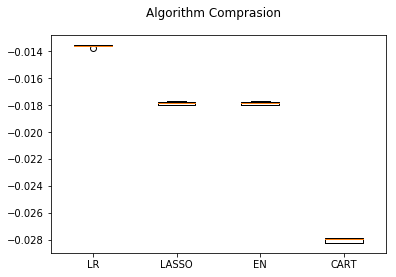

In [28]:
results=[]
names=[]
for name, model in models:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

fig=plt.figure()
fig.suptitle('Algorithm Comprasion')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Wyniki dla modeli z przeskalowanymi danymi

In [68]:
piplines=[]
piplines.append(('ScaledLR',Pipeline([('Scaler',StandardScaler()),('LR',LinearRegression())])))
piplines.append(('ScaledLASSO',Pipeline([('Scaler',StandardScaler()),('LASSO',Lasso())])))
piplines.append(('ScaledEN',Pipeline([('Scaler',StandardScaler()),('EN',ElasticNet())])))
# piplines.append(('ScaledKNN',Pipeline([('Scaler',StandardScaler()),('KNN',KNeighborsRegressor())])))#bardzo dlugo trwa jego obliczanie
piplines.append(('ScaledCART',Pipeline([('Scaler',StandardScaler()),('CART',DecisionTreeRegressor())])))
# piplines.append(('ScaledSVR',Pipeline([('Scaler',StandardScaler()),('SVR',SVR())])))#bardzo dlugo trwa jego obliczanie

results_scaled=[]
names_scaled=[]
for name, model in piplines:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results_scaled.append(cv_results)
    names_scaled.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'ScaledLR': -0.013617 (0.000065)
'ScaledLASSO': -0.017861 (0.000106)
'ScaledEN': -0.017861 (0.000106)
'ScaledCART': -0.028105 (0.000207)


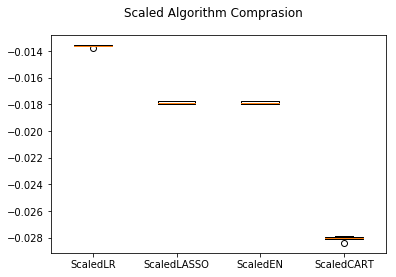

In [63]:
fig=plt.figure()
fig.suptitle('Scaled Algorithm Comprasion')
ax=fig.add_subplot(111)
plt.boxplot(results_scaled)
ax.set_xticklabels(names_scaled)
plt.show()

# Ensemble Methods (metody zespołowe)

In [57]:
ensembles=[]
# ensembles.append(('ScaledAB',Pipeline([('Scaler', StandardScaler()),('Ab',AdaBoostRegressor())])))#bardzo dlugo trwa jego obliczanie
ensembles.append(('ScaledGBM',Pipeline([('Scaler', StandardScaler()),('GBM',GradientBoostingRegressor())])))
# ensembles.append(('ScaledRF',Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))#bardzo dlugo trwa jego obliczanie
ensembles.append(('ScaledET',Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))

In [58]:
results_ensemble=[]
names_ensemble=[]
for name, model in ensembles:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results_ensemble.append(cv_results)
    names_ensemble.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'ScaledGBM': -0.013264 (0.000050)
'ScaledET': -0.013264 (0.000050)


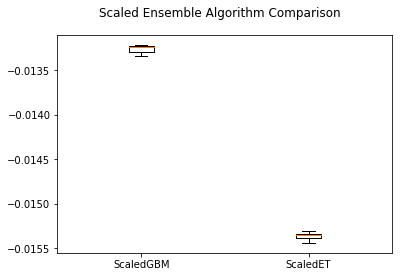

In [45]:
fig=plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results_ensemble)
ax.set_xticklabels(names_ensemble)
plt.show()

# XGBoost

In [46]:
import xgboost as xgb 

In [72]:
ensembles=[]
ensembles.append(('ScaledXGB',Pipeline([('Scaler', StandardScaler()),('XGB',xgb.XGBRegressor())])))

In [73]:
results_xgboost=[]
names_xgboost=[]
for name, model in ensembles:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results_xgboost.append(cv_results)
    names_xgboost.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'ScaledXGB': -0.028105 (0.000207)


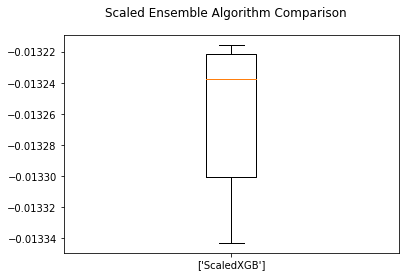

In [60]:
fig=plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results_xgboost)
ax.set_xticklabels(names_xgboost)
plt.show()

# Zestawienie przetestowanych metod

Ponieżej znajduje się wykres zawierający wyniki wszystkich przetestowanych metod. Jak widać, najlepsze rezultaty uzyskał algorytm

In [74]:
results_all=results+results_scaled+results_ensemble+results_xgboost
names_all=names+names_scaled+names_ensemble+names_xgboost

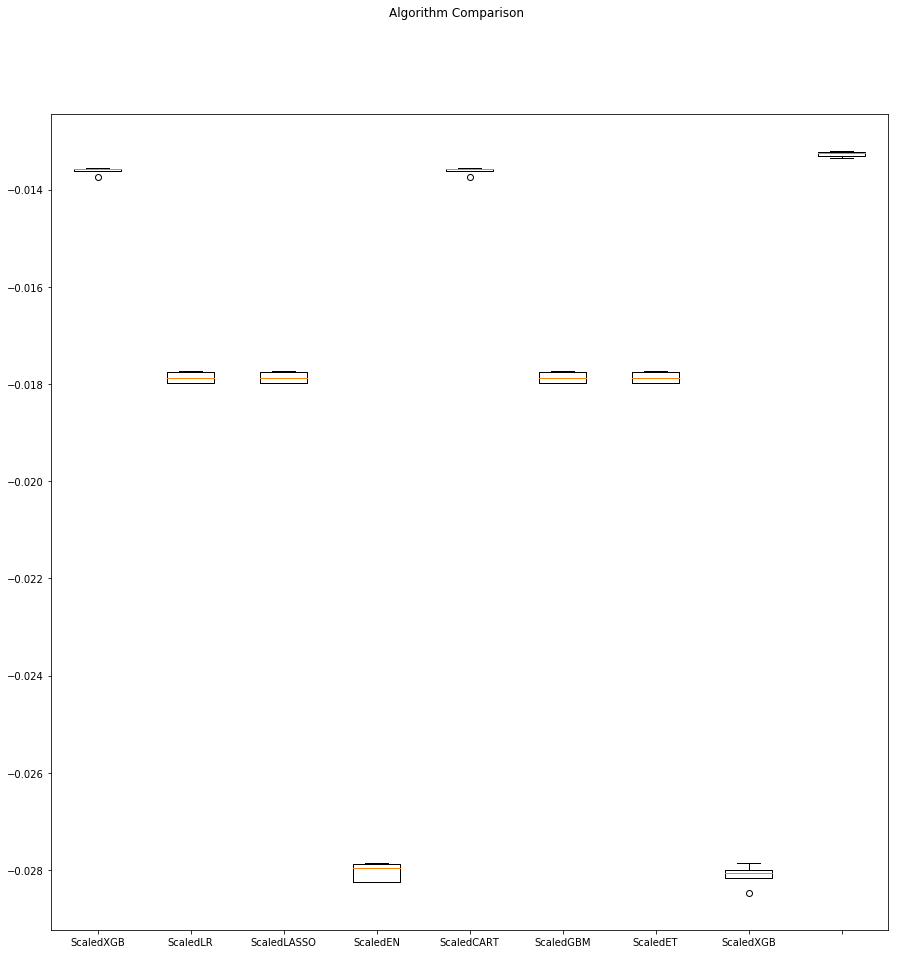

In [75]:
fig=plt.figure(figsize=(15,15))
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results_all)
ax.set_xticklabels(names_all)
# ax.
plt.show()

# Linear model

In [124]:
scaler = StandardScaler().fit(X_train)
rescaledX= scaler.transform(X_train)
model= LinearRegression()
# model=xgb.XGBRegressor()
model.fit(rescaledX,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [125]:
rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(mean_squared_error(Y_test,predictions))

0.012015815882509297


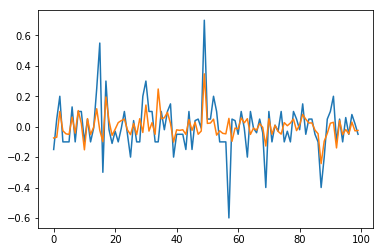

In [126]:
plt.plot(Y_test[:100])
plt.plot(predictions[:100])
plt.show()

## Porównanie algorytmów

W celu łatwiejszego porównania jakości algorytmów, wprowadzono następującą metrykę precyzji (accuracy). Mierzono kiedy algorytm poprawnie przewidział wzrotst ceny (y>0) która faktycznie zaszła TP oraz kiedy algorytm poprawnie przewidział spadek ceny (y<0) TN. Następnie obliczono ile jaki procent stanowi suma TP i TN. 

In [127]:
TP=[1 if Y_test[x]>0 and predictions[x]>0 else 0 for x in range(len(Y_test)) ]
TN=[1 if Y_test[x]<0 and predictions[x]<0 else 0 for x in range(len(Y_test)) ]

In [128]:
accuracy=(sum(TP)+sum(TN))/len(Y_test)
print('Accuracy = {:.1f}%'.format(accuracy*100))

Accuracy = 63.4%


Algorytm regresji liniowej w 63.4% procentach dobrze przewiduje, czy akcje wzrosną czy spadną

# XGBoost

In [81]:
scaler = StandardScaler().fit(X_train)
rescaledX= scaler.transform(X_train)
# model= LinearRegression()
model=xgb.XGBRegressor()
model.fit(rescaledX,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [82]:
rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(mean_squared_error(Y_test,predictions))

0.011826281154456473


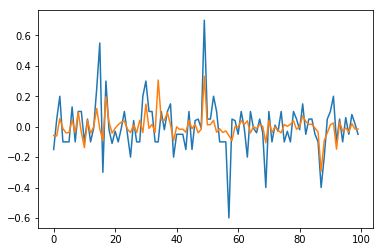

In [83]:
plt.plot(Y_test[:100])
plt.plot(predictions[:100])
plt.show()

In [86]:
TP=[1 if Y_test[x]>0 and predictions[x]>0 else 0 for x in range(len(Y_test)) ]
TN=[1 if Y_test[x]<0 and predictions[x]<0 else 0 for x in range(len(Y_test)) ]

In [111]:
accuracy=(sum(TP)+sum(TN))/len(Y_test)
print('Accuracy = {:.1f}%'.format(accuracy*100))

Accuracy = 63.9%


Algorytm XGBoost w 63.9% procentach dobrze przewiduje, czy akcje wzrosną czy spadną

# Algorytm naiwny

Algorytm naiwny przewiduje zmianę ceny jednynie na postawie ostatniej obserwacji. Wykorzystuje obserwacje, że jeśli cena akcji zmalała to prawdopodobnie następnie wzrośnie. I odwrotnie, jeśli cena spadła w danej chwili to prawdopodobnie za chwilę znowu wzrosnie. Algorytm zatem przewiduje następną zmianę jako przeciwną obecnej. 

In [88]:
# X_train=X_train[:10]
# Y_train=Y_train[:10]

In [117]:
ilosc_wszystkich_danych=Y_train.shape[0]

In [118]:
X_train_test=np.array([-X_train[:,0],Y_train])
# print(X_train_test[0])
# print(X_train_test[1])

In [119]:
suma=0

In [120]:
A=X_train_test[0] >0
B=X_train_test[1]>0
# print(A)
# print(B)
# print(A*B)
suma+=sum(A*B)

In [121]:
A=X_train_test[0] <0 
B=X_train_test[1]<0
# print(A)
# print(B)
# print(A*B)
suma+=sum(A*B)

In [122]:
B=X_train_test[1] ==0 
A=X_train_test[0] == 0
# print(A)
# print(B)
# print(sum(A*B))
suma+=sum(A*B)

In [123]:
accuracy=(suma/ilosc_wszystkich_danych)
print('Accuracy = {:.1f}%'.format(accuracy*100))

Accuracy = 63.7%


Jak widać algorytm naiwny poprawnie przewiduje zmianę ceny akcji w 63.7%

# Podsumowanie i wnioski

W czasie eksperymentu przetestowano różne algorytmy pod kątem przewidywania zmian cen akcji. Najlepsze wyniki otrzymał algorytm XGBoost (63.9%). Wynik ten jest lepszy od wyniku naiwnego algorytmu (63.7%). Regresja liniowa również osiągneła wysoki wynik (63.4%). 

Oznacza to, że metody uczenia maszynowego dają nieznacznie lepsze wyniki, jednak nie jest to bardzo duża różnica. Możliwe, że zastosowanie sieci neuronowych pozwoliłoby na osiągnięcie jeszcze lepszego rezultatu. Można również spróbować zmienić parametry modelu XGBoost co pozwoli poprawić jego rezultaty.

Ciekawym kierunkiem dalszych badań wydaje się próba zmiany ilości tranzakcji z jakich korzysta algorytm. Można również zbadać jak dobrze model sprawdza się dla akcji innych spółek. W celu potencjalnego zastosowania algorytmu do prognozowania zachowań na giełdzie, istotne byłoby przewidywanie więcej niż jednej transakcji w przód. 

Reasumując, metody uczenia maszynowego mimo, iż znajdują zastosowanie w wielu dziedzinach, są prawdopodobnie niewystarczające do przewidywania zmian kursów akcji na giełdzie.

# Załączniki

Program przygotowujący dane -- https://github.com/Moribund7/kghm_forecasting/blob/master/notebooks/Data_preparing.ipynb


Program czyszczący dane -- 
https://github.com/Moribund7/kghm_forecasting/blob/master/notebooks/data_clearing.ipynb


Dokumentacja algorytmu XGBoost --
https://xgboost.readthedocs.io/en/latest/python/python_api.html